In [2]:
!pip install torch torchvision livelossplot wandb torchtyping

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.0 MB/s eta 0:00:0000:0100:01
  Using cached torchtyping-0.1.4-py3-none-any.whl (17 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached GitPython-3.1.31-py3-none-any.whl (184 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 7.0 MB/s eta 0:00:00
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
  Using cached pathtools-0.1.2.tar.gz (11 kB)
  Preparing metadata (setup.py) ... done
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.2/397.2 kB 10.4 MB/s eta 0:00:00
  Using cached gitdb-4.0.10-py3-none-any.whl (62 kB)
  Using cached smmap-5.0.0-py3-none-any.whl (24 kB)
  DEPRECATION: pathtools is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--us

## Libraries

In [1]:
import sys
import os
# Add spectroscope to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from livelossplot import PlotLosses

from spectroscope.data import SubsetsLoader, get_filtered_dataset

# Data

In [3]:
# Load the data
mnist_train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

## Single-layer neural network

This an unmodified mnist learner

In [4]:
DEVICE = torch.device("cpu") # Uncomment this to run on CPU
# DEVICE = torch.device("cuda:0") # Uncomment this to run on GPU

class MNISTConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(512, 10)

        self.to(DEVICE)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 512)
        x = self.fc1(x)
        return x

# START OF IDEA: Introduction of new digits in training

The section aims to see if introducing new digits later in the Epoch gives discontinuous boosts in peformance. I expect it shouldn't, since if we have the model say learn just 0 and 1 in the first half of training, then introduce the number 2, the parameters will be fitted only to (0,1) and do terrible on 2, so I expect a massive dip in accuracy in the middle, then some recovery at the end once it's seen some 0,1,2s but nowhere near the 90%+ as if we just did all 10 from the start. It's highly possible I may have misunderstood the setup, since I don't see how this could give a phase transition in decrease of loss. 

The code below is simply testing the filter digit function does as expected

In [23]:

from typing import Any, Tuple, Type

import torch
from torch.utils.data import DataLoader, Dataset
from torchtyping import TensorType


def as_subset(cls: Type[Dataset]):
    """
    Wrapper for a dataset class that adds a labels attribute to the dataset,
    and a __repr__ method that prints the labels.
    """
    class Subset(cls):
        def __init__(self, data, targets, train: bool, labels: Tuple[int, ...], **kwargs):
            self.labels = labels
            self.data = data
            self.targets = targets

            self.train = train

        def __repr__(self):
            return f"Subset({self.__class__.__name__}, labels={self.labels})"
        
        def __getitem__(self, index: int) -> Tuple[Any, Any]:
            """
            Args:
                index (int): Index

            Returns:
                tuple: (image, target) where target is index of the target class.
            """
            return self.data[index], int(self.targets[index])
    
    return Subset


def filter_by_labels(dataset: Dataset, labels: Tuple[int, ...]):
    """
    Returns an iterator over the dataset, yielding only the images and labels in labels.
    """
    for image, label in dataset:
        if label in labels:
            yield image, label


def get_filtered_dataset(dataset: Dataset, labels: Tuple[int, ...]):
    """
    Returns a new dataset with only the images and labels in labels.
    """
    dataset_cls = as_subset(type(dataset))
    data, targets = zip(*((x, y) for x, y in filter_by_labels(dataset, labels)))
    return dataset_cls(data, targets, train=dataset.train, labels=labels)  # type: ignore

class SubsetsLoader(DataLoader):
    """
    A data loader that trains on different subsets of the dataset 
    depending on the active subset.

    Note: it's up to you to call next_subset() when you want to move to the next subset.
    """

    def __init__(
        self,
        subsets: Tuple[Dataset],
        *args,
        **kwargs,
    ):
        self.subsets = subsets
        self.subset_idx = 0
        self.dataset = subsets[0]

        super().__init__(self.dataset, *args, **kwargs)

    def next_subset(self):
        """Moves to the next subset."""
        if self.subset_idx < len(self.subsets):
            self.subset_idx += 1
            self.dataset = self.subsets[self.subset_idx]     
        else:
            raise StopIteration
        
    def to_subset(self, subset_idx: int):
        """Moves to the subset with index subset_idx."""
        if subset_idx < len(self.subsets):
            self.subset_idx = subset_idx
            self.dataset = self.subsets[subset_idx]     
        else:
            raise IndexError(f"Subset index {subset_idx} out of range")

    @classmethod
    def from_filters(cls, dataset: Dataset, labels_per_subset: Tuple[Tuple[int, ...]]):
        """
        Returns a SubsetsLoader that trains on different subsets of the dataset 
        depending on the active subset.
        """
        subsets = tuple(get_filtered_dataset(dataset, labels) for labels in labels_per_subset)
        return cls(subsets, shuffle=True)

        
    def __repr__(self):
        return f"SubsetsLoader({self.subsets}, batch_size={self.batch_size})"

subsets_loader = SubsetsLoader.from_filters(
    mnist_train,
    labels_per_subset=tuple(tuple(range(i)) for i in range(1, 10)),
)

subsets_loader

SubsetsLoader((Subset(Subset, labels=(0,)), Subset(Subset, labels=(0, 1)), Subset(Subset, labels=(0, 1, 2)), Subset(Subset, labels=(0, 1, 2, 3)), Subset(Subset, labels=(0, 1, 2, 3, 4)), Subset(Subset, labels=(0, 1, 2, 3, 4, 5)), Subset(Subset, labels=(0, 1, 2, 3, 4, 5, 6)), Subset(Subset, labels=(0, 1, 2, 3, 4, 5, 6, 7)), Subset(Subset, labels=(0, 1, 2, 3, 4, 5, 6, 7, 8))), batch_size=1)

In [24]:
per_label_train_loader = SubsetsLoader.from_filters(
    mnist_train,
    labels_per_subset=tuple((i,) for i in range(1, 10)),
)

per_label_test_loader = SubsetsLoader.from_filters(
    mnist_test,
    labels_per_subset=tuple((i,) for i in range(1, 10)),
)

In [26]:
class Metrics:
    def __init__(self, per_label_train_loader, per_label_test_loader, loss_fn):
        self.per_label_train_loader = per_label_train_loader
        self.per_label_test_loader = per_label_test_loader
        self.loss_fn = loss_fn

        self.train_loss = np.zeros(10)
        self.train_accuracy = np.zeros(10)
        self.test_loss = np.zeros(10)
        self.test_accuracy = np.zeros(10)

        self.trainset_sizes = np.array([len(subset) for subset in per_label_train_loader.subsets])
        self.testset_sizes = np.array([len(subset) for subset in per_label_test_loader.subsets])

    def measure(self, model: nn.Module):
        with torch.no_grad():
            # Loop over each specific-label-restricted subset of data
            for l in range(10):
                per_label_train_loader.to_subset(l)
                per_label_test_loader.to_subset(l)

                for i, (x, y) in enumerate(per_label_train_loader):
                    x, y = x.to(DEVICE), y.to(DEVICE)
                    y_pred = model(x)
                    _, predicted = torch.max(y_pred.data, 1)
                    self.train_accuracy[l] += (predicted == y).sum().item()
                    self.train_loss[l] += self.loss_fn(y_pred, y).item()

                self.train_accuracy[l] /= self.trainset_sizes[l]
                self.train_loss[l] /= self.trainset_sizes[l]

                for i, (x, y) in enumerate(per_label_test_loader):
                    x, y = x.to(DEVICE), y.to(DEVICE)
                    y_pred = model(x)
                    _, predicted = torch.max(y_pred.data, 1)
                    self.test_accuracy[l] += (predicted == y).sum().item()
                    self.test_loss[l] += loss_fn(y_pred, y).item()

                self.test_accuracy[l] /= self.testset_sizes[l]
                self.test_loss[l] /= self.testset_sizes[l]

    def reset(self):
        self.train_loss = np.zeros(10)
        self.train_accuracy = np.zeros(10)
        self.test_loss = np.zeros(10)
        self.test_accuracy = np.zeros(10)

    @property
    def total_train_size(self):
        return self.trainset_sizes.sum() 
    
    @property
    def total_test_size(self):
        return self.testset_sizes.sum()

    @property
    def total_train_loss(self):
        return (self.train_loss * self.trainset_sizes).sum() / self.total_train_size
    
    @property
    def total_test_loss(self):
        return (self.test_loss * self.testset_sizes).sum() / self.total_test_size

    @property
    def total_train_accuracy(self):
        return (self.train_accuracy * self.trainset_sizes).sum() / self.total_train_size
    
    @property
    def total_test_accuracy(self):
        return (self.test_accuracy * self.testset_sizes).sum() / self.total_test_size

    def as_dict(self):
        d = {
            "train/loss/total": self.total_train_loss,
            "test/loss/total": self.total_test_loss,
            "train/accuracy/total": self.total_train_accuracy,
            "test/accuracy/total": self.total_test_accuracy,
        }

        for l in range(10):
            d[f"train/loss/{l}"] = self.train_loss[l]
            d[f"test/loss/{l}"] = self.test_loss[l]
            d[f"train/accuracy/{l}"] = self.train_accuracy[l]
            d[f"test/accuracy/{l}"] = self.test_accuracy[l]

        return d      

Now we check whether we still get good accuracy with only 0, 1 and 2 in the dataset


So as we can see we still get good accuracy with less digits, althought there appears to be much more variation in the accuracy which was not expected, and that it takes longer to get to a good accuracy which doesnt make much sense to me. Now we will try to train this model to learn on 0s and 1s only, then we introduce 2 halfway into the second half of training (Epoch 50) to see if there is discontinuity in performance

In [27]:
import wandb

def train(model: nn.Module, loss_fn, optimizer, subsets_loader: SubsetsLoader, metrics: Metrics):
    wandb.init("detecting-phase-transitions")

    step = 0
    
    # Epochs change in size, so we want to keep the number of steps constant between changes
    while step < 10_000: 
        train_loss = 0.

        # Training loop for mini-batches
        for x, y in subsets_loader:
            if step % 1000 == 0 and step > 0:
                subsets_loader.next_subset()
                print("Next subset:", subsets_loader.dataset)
            
            if step % 100 == 0:
                metrics.reset()
                metrics.measure(model)
                wandb.log(metrics.as_dict(), step=step)
            
            # Make predictions with the current parameters.
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred = model(x)

            # Compute the loss value.
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # Update the parameters.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            step += 1

    wandb.finish()

model = MNISTConvNet()
loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)
metrics = Metrics(per_label_train_loader, per_label_test_loader, loss_fn)

train(model, loss_fn, optimizer, subsets_loader, metrics)

/Users/Jesse/Projects/detecting-phase-transitions/.venv/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


ValueError: dataset attribute should not be set after SubsetsLoader is initialized

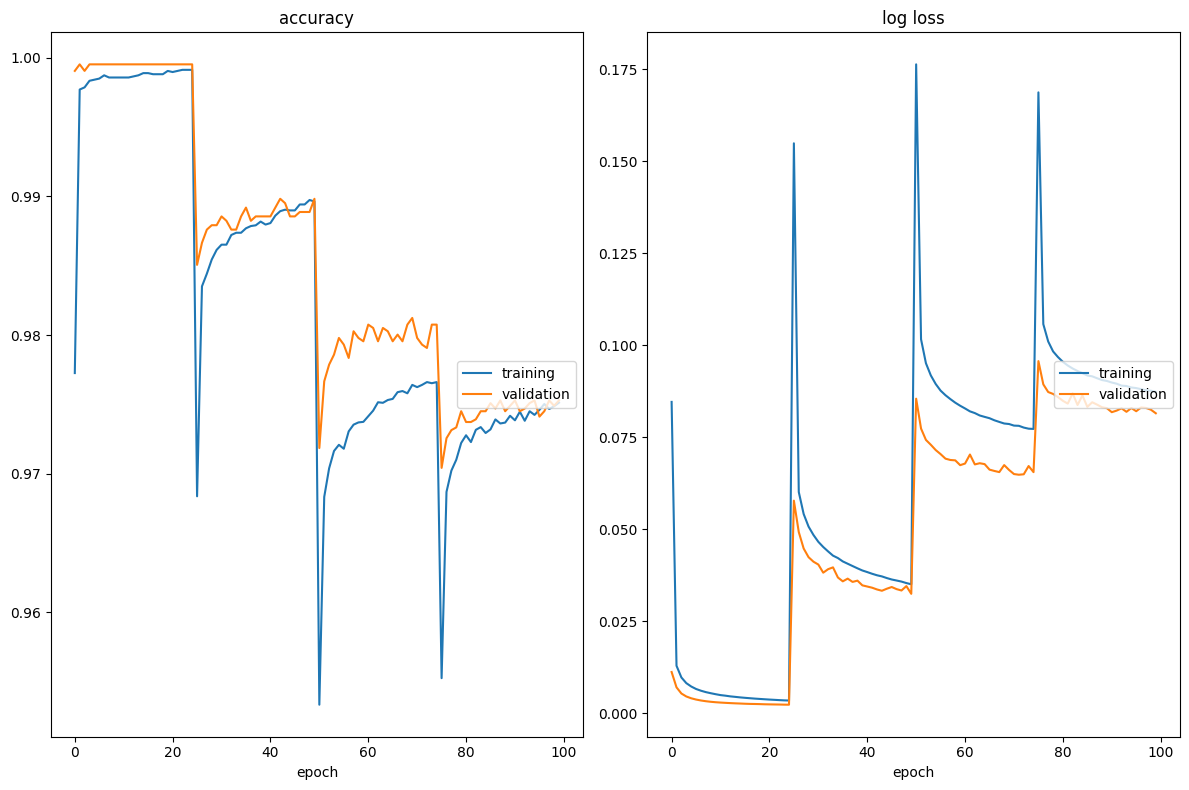

accuracy
	training         	 (min:    0.953, max:    0.999, cur:    0.975)
	validation       	 (min:    0.970, max:    1.000, cur:    0.975)
log loss
	training         	 (min:    0.003, max:    0.176, cur:    0.087)
	validation       	 (min:    0.002, max:    0.096, cur:    0.081)
Accuracy: 0.9753 (test), 0.9751 (train)


In [ ]:
model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
model.to(device)

# Filter the dataset for specific digits (Sorry its not in a loop)
digits_to_keep_1 = [0, 1]
train_images_1, train_labels_1 = filter_mnist_by_digits(mnist_train, digits_to_keep_1)
test_images_1, test_labels_1 = filter_mnist_by_digits(mnist_test, digits_to_keep_1)

train_set_1 = create_dataset(train_images_1, train_labels_1)
test_set_1 = create_dataset(test_images_1, test_labels_1)

digits_to_keep_2 = [0, 1, 2]
train_images_2, train_labels_2 = filter_mnist_by_digits(mnist_train, digits_to_keep_2)
test_images_2, test_labels_2 = filter_mnist_by_digits(mnist_test, digits_to_keep_2)

train_set_2 = create_dataset(train_images_2, train_labels_2)
test_set_2 = create_dataset(test_images_2, test_labels_2)

digits_to_keep_3 = [0, 1, 2, 3]
train_images_3, train_labels_3 = filter_mnist_by_digits(mnist_train, digits_to_keep_3)
test_images_3, test_labels_3 = filter_mnist_by_digits(mnist_test, digits_to_keep_3)

train_set_3 = create_dataset(train_images_3, train_labels_3)
test_set_3 = create_dataset(test_images_3, test_labels_3)

digits_to_keep_4 = [0, 1, 2, 3, 4]
train_images_4, train_labels_4 = filter_mnist_by_digits(mnist_train, digits_to_keep_4)
test_images_4, test_labels_4 = filter_mnist_by_digits(mnist_test, digits_to_keep_4)

train_set_4 = create_dataset(train_images_4, train_labels_4)
test_set_4 = create_dataset(test_images_4, test_labels_4)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()

for t in range(100):
    # Set the digits for the current epoch
    if t < 25:
        #digits_to_keep = [0, 1]
        train_loader = DataLoader(train_set_1, batch_size=256, shuffle=True)
        test_loader = DataLoader(test_set_1, batch_size=128)
    elif t < 50:
        train_loader = DataLoader(train_set_2, batch_size=256, shuffle=True)
        test_loader = DataLoader(test_set_2, batch_size=128)
    elif t < 75:
        train_loader = DataLoader(train_set_3, batch_size=256, shuffle=True)
        test_loader = DataLoader(test_set_3, batch_size=128)   
    else:
        #digits_to_keep = [0, 1, 2]
        train_loader = DataLoader(train_set_4, batch_size=256, shuffle=True)
        test_loader = DataLoader(test_set_4, batch_size=128)

    train_loss = 0.
    train_correct = 0

    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()

        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))

    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))